In [37]:
from __future__ import division
import pystan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
from matplotlib.patches import Ellipse
%matplotlib inline

In [38]:
#Stan block
#increment_log_posterior is a sum of Maxwell-Boltzmann and Gibbs distributions
#T1 and T2 are sufficient statistics which are sums of squares of x and v

mvoup_stat = """
data {
    int<lower=0> N;    // number of data points
    real<lower=0> dt;  // sampling interval  
    real x[N];         // positions 
    real v[N];         // velocities
    real beta;         // 1/k_B*T
}
transformed data {
    real T1;           // sufficient statistics
    real T2;
    T1 <- 0;
    T2 <- 0;
    for (n in 1:N){
         T1 <- T1 + x[n]*x[n];
         T2 <- T2 + v[n]*v[n];
    }
}
parameters {
    real<lower=0> k;  // trap stiffness
    real<lower=0> m; //mass
}
transformed parameters {
}
model {
    increment_log_prob((N/2)*log(beta*k/(2*pi()))+(N/2)*log(beta*m/(2*pi()))-0.5*beta*k*T1-0.5*beta*m*T2);
}
generated quantities {
}
"""

# model compilation
model = pystan.StanModel(model_code=mvoup_stat)

In [39]:
#Known parameters and physical constants
#Sampling frequency, Temperature, Boltzmann constant and number of data of points

f_sam = 65536 #Hz
dt = 1/f_sam
k_B = 1.38064881313131e-23  # Boltzmann constant (Newton metre/Kelvin)
T = 275 #Kelvin
beta = 1/(k_B*T)
N = 65536 #Number of data points

In [40]:
#Load simulated position and velocity data from text files

x = np.fromfile('position.txt',dtype=float,count=-1,sep = " ").reshape(N,)
v = np.fromfile('velocity.txt',dtype = float, count=-1, sep = " ").reshape(N,)

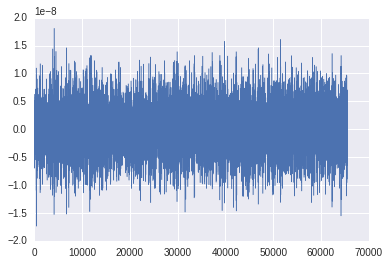

In [41]:
#plot position data
plt.plot(x,linewidth=0.5)

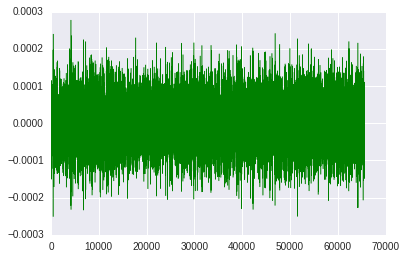

In [42]:
#plot velocity data
plt.plot(v,linewidth=0.5,color = 'g')

In [43]:
#providing experimental data
MVOU_data = { 'N':N, 'dt':dt, 'x':x, 'v':v, 'beta':beta}

(Inference for Stan model: anon_model_4da46e0c6191a8de1faffe5a919117ba.
 4 chains, each with iter=1000; warmup=500; thin=1; 
 post-warmup draws per chain=500, total post-warmup draws=2000.
 
        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
 k    2.2e-4  5.4e-8 1.3e-6 2.2e-4 2.2e-4 2.2e-4 2.2e-4 2.2e-4  530.0    nan
 m   9.8e-13 2.6e-165.8e-159.7e-139.8e-139.8e-139.9e-139.9e-13  509.0    nan
 lp__  1.7e6    0.06   1.08  1.7e6  1.7e6  1.7e6  1.7e6  1.7e6  323.0    1.0
 
 Samples were drawn using NUTS(diag_e) at Thu Mar 23 16:40:18 2017.
 For each parameter, n_eff is a crude measure of effective sample size,
 and Rhat is the potential scale reduction factor on split chains (at 
 convergence, Rhat=1).,
 <matplotlib.figure.Figure at 0x7f0878c8d190>)

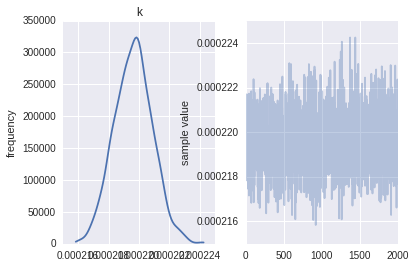

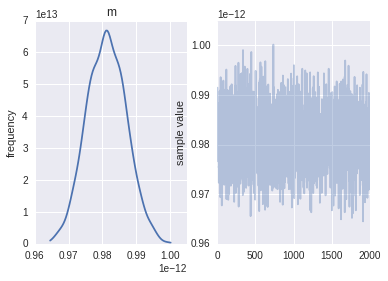

In [44]:
#model fitting using MCMC
fit_stan = model.sampling(data=MVOU_data, chains=4, iter=1000)
fit_stan, fit_stan.plot('k'), fit_stan.plot('m')

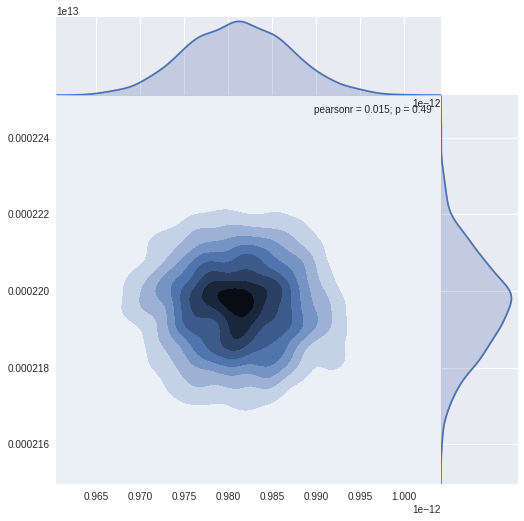

In [45]:
#sampling from the posterior
m_samples = fit_stan.extract()['m']
k_samples = fit_stan.extract()['k']
g = sns.jointplot(m_samples, k_samples, kind="kde", size=7, space=0)

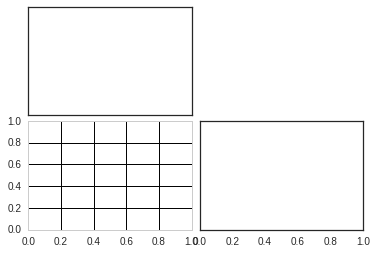

In [46]:
#Preparing the corner plots
#Configure empty grids
gs = gridspec.GridSpec(nrows=2,ncols=2,height_ratios = [1,1],width_ratios=[1,1],wspace =0.05,hspace = 0.05)
with sns.axes_style("white"):
    ax1 = plt.subplot(gs[0,0])
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
with sns.axes_style("whitegrid",{"grid.color": "0.01"}):
    ax2 = plt.subplot(gs[1,0])
with sns.axes_style("white"):
    ax3 = plt.subplot(gs[1,1])
    ax3.axes.get_yaxis().set_visible(False)

#Rename sample variables    
m_stat_vec = m_samples
k_stat_vec = k_samples

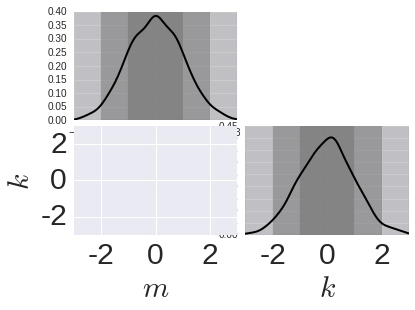

In [47]:
#Scale samples of m and k to N(0,1)
# m' = {m - mean(m)}/sigma(m)  
# k' = {k - mean(k)}/sigma(k)

m_stat_vec = (m_stat_vec-np.mean(m_stat_vec))/np.std(m_stat_vec)
k_stat_vec = (k_stat_vec-np.mean(k_stat_vec))/np.std(k_stat_vec)


#Covariance ellipses for bivariate plot
#Ellipse for 1-sigma
lambda_10, v_10 = np.linalg.eig(np.cov(m_stat_vec, k_stat_vec))
lambda_10 = np.sqrt(lambda_10)
ell_101 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*2, height=lambda_10[1]*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_101.set_facecolor('gray')
ell_101.set_alpha(0.8)
ax2.add_artist(ell_101)

#Ellipse for 2-sigma
ell_102 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*2*2, height=lambda_10[1]*2*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_102.set_facecolor('gray')
ell_102.set_alpha(0.6)
ax2.add_artist(ell_102)

#Ellipse for 3-sigma
ell_103 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*3*2, height=lambda_10[1]*3*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_103.set_facecolor('gray')
ell_103.set_alpha(0.4)
ax2.add_artist(ell_103)

#Subplots for corner plot
#Histogram of mass subplot
plt.subplot(gs[0,0])
sns.distplot(m_stat_vec, hist = False, kde_kws={"color": "k", "lw":2})
plt.axvspan(-np.std(m_stat_vec), np.std(m_stat_vec), alpha=0.8, color='gray')
plt.axvspan(-2*np.std(m_stat_vec), 2*np.std(m_stat_vec), alpha=0.6, color='gray')
plt.axvspan(-3*np.std(m_stat_vec), 3*np.std(m_stat_vec), alpha=0.4, color='gray')
plt.xlim([-3,3])

#Histogram of k subplot
plt.subplot(gs[1,1])
sns.distplot(k_stat_vec, hist = False,kde_kws={"color": "k", "lw":2})
plt.axvspan(-np.std(k_stat_vec), np.std(k_stat_vec), alpha=0.8, color='gray')
plt.axvspan(-2*np.std(k_stat_vec), 2*np.std(k_stat_vec), alpha=0.6, color='gray')
plt.axvspan(-3*np.std(k_stat_vec), 3*np.std(k_stat_vec), alpha=0.4, color='gray')
plt.xlim([-3,3])
plt.xticks([-2,0,2],[-2,0,2],fontsize=30)
plt.xlabel(r'$k$',fontsize=30)

#Joint distribution subplot
plt.subplot(gs[1,0])
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xticks([-2,0,2],[-2,0,2],fontsize=30)
plt.yticks([-2,0,2],[-2,0,2],fontsize=30)
plt.xlabel(r'$m$',fontsize=30)
plt.ylabel(r'$k$',fontsize=30)
ax2.plot(0,0,'ok')

plt.show()

(-3, 3)

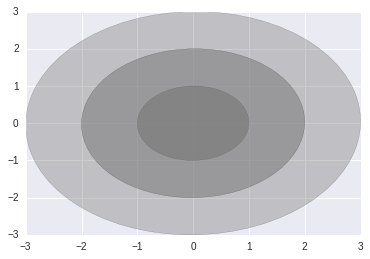

In [48]:
#Covariance ellipses for bivariate plot
f, ax = plt.subplots()
#Ellipse for 1-sigma
lambda_10, v_10 = np.linalg.eig(np.cov(m_stat_vec, k_stat_vec))
lambda_10 = np.sqrt(lambda_10)
ell_101 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*2, height=lambda_10[1]*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_101.set_facecolor('gray')
ell_101.set_alpha(0.8)
ax.add_artist(ell_101)

#Ellipse for 2-sigma
ell_102 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*2*2, height=lambda_10[1]*2*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_102.set_facecolor('gray')
ell_102.set_alpha(0.6)
ax.add_artist(ell_102)

#Ellipse for 3-sigma
ell_103 = Ellipse(xy=(np.mean(m_stat_vec), np.mean(k_stat_vec)),
                  width=lambda_10[0]*3*2, height=lambda_10[1]*3*2,
                  angle=np.rad2deg(np.arccos(v_10[0, 0])))
ell_103.set_facecolor('gray')
ell_103.set_alpha(0.4)
ax.add_artist(ell_103)

plt.xlim([-3,3])
plt.ylim([-3,3])